# 0.0. IMPORTS

In [21]:
import pandas as pd
#import inflection
#import math
import numpy as np
import seaborn as sns
import datetime
#import pickle

#from scipy import stats as ss
from matplotlib import pyplot as plt
from IPython.core.display import HTML
#from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
#, Lasso

from boruta import BorutaPy
import xgboost as xgb
#import random
#import warnings
#warnings.filterwarnings('ignore')

## 0.1. Funções de Ajuda

In [22]:
def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse
                        }, index=[0])


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [23]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Carregando Dados

In [24]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_sales_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [25]:
df_family_expenses_raw = pd.read_excel('data/pordata.xlsx', sheet_name='Quadro_Formatado')

# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [26]:
df1 = df_sales_raw.copy()

In [27]:
df1.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [28]:
df1_aux = df_family_expenses_raw.copy()

In [29]:
df1_aux.dtypes

Anos                                              int64
Tipo de bens e serviços                          object
UE27 (2020) - União Europeia 27 (desde 2020)    float64
UE28 - União Europeia (28 Países)               float64
ZE19 - Zona Euro (19 Países)                    float64
DE - Alemanha                                     int64
AT - Áustria                                    float64
BE - Bélgica                                    float64
BG - Bulgária                                   float64
CY - Chipre                                     float64
HR - Croácia                                    float64
DK - Dinamarca                                  float64
SK - Eslováquia                                 float64
SI - Eslovénia                                  float64
ES - Espanha                                      int64
EE - Estónia                                    float64
FI - Finlândia                                    int64
FR - França                                     

## 1.1 Renomeando Colunas

In [30]:
cols_new = [ 'store',
             'day_of_week',
             'date',
             'sales',
             'customers',
             'open',
             'promo',
             'state_holiday',
             'school_holiday',
             'store_type',
             'assortment',
             'competition_distance',
             'competition_open_since_month',
             'competition_open_since_year',
             'promo2',
             'promo2_since_week',
             'promo2_since_year',
             'promo_interval'
           ]

#renomear
df1.columns = cols_new

In [31]:
# formatando dataset pra melhor visualização dos dados
anos = df1_aux['Anos'].drop_duplicates()
paises = df1_aux.columns.drop(['Anos','Tipo de bens e serviços'])

colunas = ['total', 
           'produtos_alimentares_bebida_nao_alcoolica', 
           'bebidas_alcoolicas_tabaco_narcoticos', 
           'vestuario_calcado', 
           'habitacao_agua_eletricidade_gas_outros_combustiveis', 
           'acessorios_lar_equipamento_doméstico_manutencao', 
           'saude', 'transportes', 
           'comunicacoes', 
           'lazer_recreacao_cultura', 
           'educacao', 
           'restaurantes_hoteis', 
           'bens_servicos_diversos']
colunas.insert(0,'ano')
colunas.insert(1,'pais')
df_family_expenses_format = pd.DataFrame(columns=colunas)

for ano in anos:
    for pais in paises:
        aux = df1_aux[pais][df1_aux['Anos'] == ano].T.values.tolist()
        aux.insert(0, ano)
        aux.insert(1, pais)
        df_family_expenses_format.loc[len(df_family_expenses_format)] = aux

df1_aux = df_family_expenses_format

## 1.2 Dimensões dos Dados

In [32]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


In [33]:
print('Number of Rows: {}'.format(df1_aux.shape[0]))
print('Number of Cols: {}'.format(df1_aux.shape[1]))

Number of Rows: 374
Number of Cols: 15


## 1.3 Tipo dos Dados

In [34]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Verificando NA

In [35]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [37]:
df1_aux.isna().sum()

ano                                                    0
pais                                                   0
total                                                  0
produtos_alimentares_bebida_nao_alcoolica              0
bebidas_alcoolicas_tabaco_narcoticos                   0
vestuario_calcado                                      0
habitacao_agua_eletricidade_gas_outros_combustiveis    0
acessorios_lar_equipamento_doméstico_manutencao        0
saude                                                  0
transportes                                            0
comunicacoes                                           0
lazer_recreacao_cultura                                0
educacao                                               0
restaurantes_hoteis                                    0
bens_servicos_diversos                                 0
dtype: int64

## 1.5 Preencher NA

In [38]:
df1['competition_distance'].max()

75860.0

In [39]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
df1['promo_interval'].fillna(0, inplace=True)

In [40]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 1.6 Alterando Tipo de Dados

In [41]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [42]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Estatística Descritiva

In [43]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Atributos Numéricos

In [44]:
# Tendência Central - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std (desvio padrão), min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenação
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['atributos','min','max','range','mean','median','std','skew','kurtosis']

In [45]:
m

,atributos,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


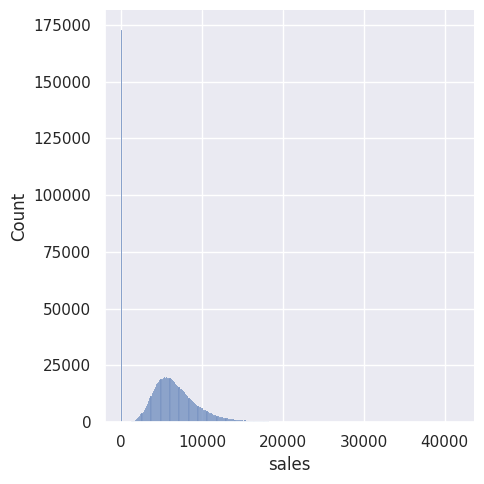

In [46]:
sns.displot(df1['sales'], bins=300)

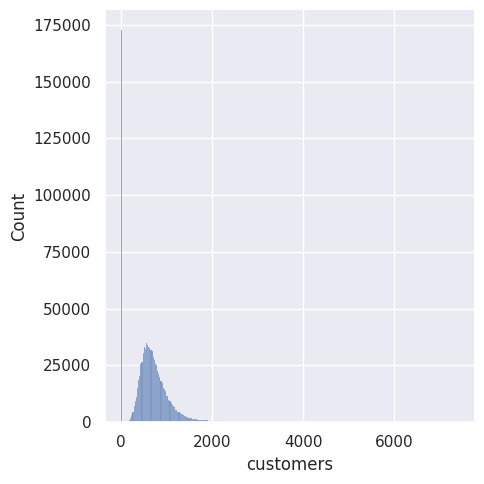

In [47]:
sns.displot(df1['customers'], bins=300)

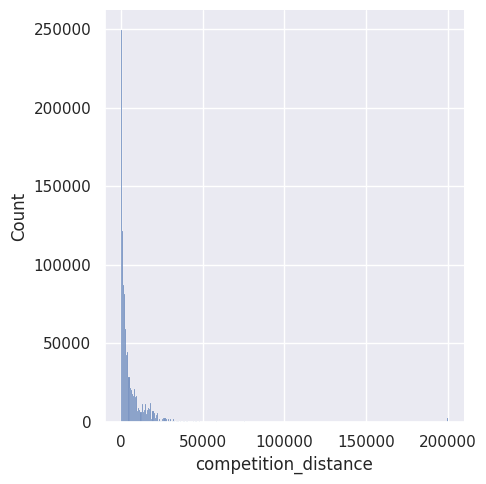

In [48]:
sns.displot(df1['competition_distance'], bins=300)

### 1.7.2 Atributos Categóricos

In [49]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

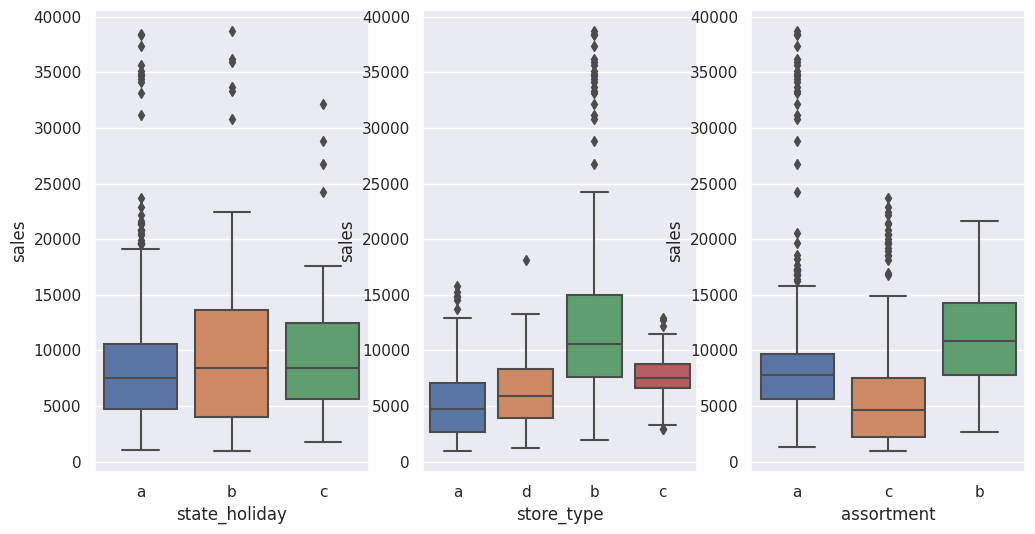

In [50]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux)

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [51]:
df2 = df1.copy()

## 2.1 Feature Engineering

In [52]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extend')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# is promo
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df2['month_map'] = df2['date'].dt.month.map(month_map)

df2['is_promo'] = df2[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [53]:
df2.sample(5).T

,990275,326271,223913,520237,689522
store,941,162,914,318,123
day_of_week,5,5,1,6,1
date,2013-01-25 00:00:00,2014-09-26 00:00:00,2015-01-12 00:00:00,2014-03-22 00:00:00,2013-10-21 00:00:00
sales,4795,5929,11937,5480,12584
customers,548,475,1281,480,1332
open,1,1,1,1,1
promo,1,0,1,0,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,1
store_type,a,d,c,d,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [54]:
df3 = df2.copy()
df3_aux = df1_aux.copy()

In [55]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,Jul,1
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,Jul,1
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extend,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,Jul,0


## 3.1 Filtragem das Linhas

In [56]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)] # open: loja fechada não têm vendas / sales: loja sem vendas

df3_aux = df3_aux.query('ano in (2013,2014,2015) and \
                         pais in (\'DE - Alemanha\', \
                                  \'PL - Polónia\', \
                                  \'HU - Hungria\', \
                                  \'CZ - República Checa\', \
                                  \'ES - Espanha\')'
                       )

## 3.2 Seleção das Colunas

In [57]:
cols_drop = ['customers','open','promo_interval', 'month_map'] # customers: no momento da predição, não saberemos qual a quantidade de clientes
df3 = df3.drop(cols_drop, axis=1)

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS - EDA

In [58]:
df4 = df3.copy()

In [59]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 Criação das Hipóteses

**H1.**		Lojas com maior variedade deveriam vender mais.

**H2.**		Lojas com concorrentes mais próximos deveriam vender menos.

**H3.**		Lojas com concorrentes há mais tempo deveriam vendem mais.

**H4.**		Lojas com promoções ativas por mais tempo deveriam vender mais.

**H5.**		Lojas com mais promoções consecutivas deveriam vender mais.

**H6.**		Lojas abertas durante o feriado de Natal deveriam vender mais.

**H7.**		Lojas deveriam vender mais ao longo dos anos.

**H8.**		Lojas deveriam vender mais no segundo semestre do ano.

**H9.**		Lojas deveriam vender menos aos finais de semana.

**H10.**	Lojas deveriam vender menos durante os feriados escolares.

## 4.2 Análise Univariada

### 4.2.1 Variável Resposta

In [ ]:
sns.displot(df4['sales'])

### 4.2.2 Variáveis Numéricas

In [ ]:
num_attributes.hist(bins=25);

### 4.2.3 Variáveis Categóricas

In [ ]:
df4['state_holiday'].drop_duplicates()

In [ ]:
df4['assortment'].drop_duplicates()

In [ ]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a)

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill = True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill = True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extend']['sales'], label='extend', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill = True)
plt.legend()

## 4.3 Análise Bivariada

### **H1.** Lojas com maior variedade deveriam vender mais.
**FALSE** Lojas com MAIOR VARIEDADE vendem MENOS - RELEVÂNCIA BAIXA

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data= aux1);

In [ ]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

In [ ]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

In [ ]:
aux3.head()

### **H2.** Lojas com concorrentes mais próximos deveriam vender menos.
**FALSE** Lojas com concorrentes MAIS PRÓXIMOS vendem MAIS - RELEVÂNCIA MÉDIA

In [ ]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

In [ ]:
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

In [ ]:
sns.heatmap(aux1.corr(), annot=True);

### **H3.** Lojas com concorrentes há mais tempo deveriam vendem mais.
**FALSE** Lojas com concorrentes HÁ MAIS TEMPO vendem MENOS - RELEVÂNCIA MÉDIA

In [ ]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation = 90);

In [ ]:
sns.scatterplot(x='competition_time_month', y='sales', data=aux2)

In [ ]:
sns.heatmap(aux1.corr(), annot=True)

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSE** Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO vendem MENOS, depois de um certo período de promoção - RELEVÂNCIA BAIXA

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()


aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation = 90);

In [ ]:
aux3= aux1[aux1['promo_time_week'] <0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation = 90);

In [ ]:
plt.subplot(1,2,1)
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(1,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux3);

In [ ]:
sns.heatmap(aux1.corr(), annot=True)

### **H5.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSE** Lojas com PROMOÇÕES CONSECUTIVAS vendem MENOS - RELEVÂNCIA BAIXA

In [ ]:
df4[['promo','promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values(by=['sales'], ascending=False).reset_index()

### **H6.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSE** Lojas ABERTAS DURANTE O FERIADO DE NATAL vendem MENOS - RELEVÂNCIA MÉDIA

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

In [ ]:
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H7.** Lojas deveriam vender mais ao longo dos anos.
**FALSE** Lojas vendem MENOS AO LONGO DO ANO - RELEVÂNCIA ALTA

In [ ]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

sns.barplot(x='year', y='sales', data=aux1);

In [ ]:
sns.regplot(x='year', y='sales', data=aux1);

In [ ]:
sns.heatmap(aux1.corr(), annot=True);

### **H8.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSE** Lojas vendem MENOS NO SEGUNDO SEMESTRE DO ANO - RELEVÂNCIA ALTA

In [ ]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

sns.barplot(x='month', y='sales', data=aux1);

In [ ]:
sns.regplot(x='month', y='sales', data=aux1);

In [ ]:
sns.heatmap(aux1.corr(), annot=True);

### **H9.** Lojas deveriam vender menos aos finais de semana.
**TRUE** Lojas vendem MENOS AOS FINAIS DE SEMANA - RELEVÂNCIA ALTA

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

sns.barplot(x='day_of_week', y='sales', data=aux1);

In [ ]:
sns.regplot(x='day_of_week', y='sales', data=aux1);

In [ ]:
sns.heatmap(aux1.corr(), annot=True);

### **H10.** Lojas deveriam vender menos durante os feriados escolares.
**TRUE** Lojas vendem MENOS DURANTE OS FERIADOS ESCOLARES, EXCETO OS MESES DE JULHO E AGOSTO - RELEVÂNCIA BAIXA

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

sns.barplot(x='school_holiday', y='sales', data=aux1);

In [ ]:
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das Hipóteses

In [ ]:
from tabulate import tabulate

In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', 'Falsa', 'Baixa'],
      ['H6', 'Falsa', 'Media'],
      ['H7', 'Falsa', 'Alta'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Verdadeira', 'Alta'],
      ['H10', 'Verdadeira', 'Baixa'],
     ]
print( tabulate( tab, headers='firstrow' ) )

### 4.3.1 Numerical Attributes

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot= True)

### 4.3.2 Categorical Attributes

In [ ]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]
                 })
d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0 PASSO 05 - PREPARAÇÃO DOS DADOS

In [60]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

<AxesSubplot: xlabel='competition_time_month'>

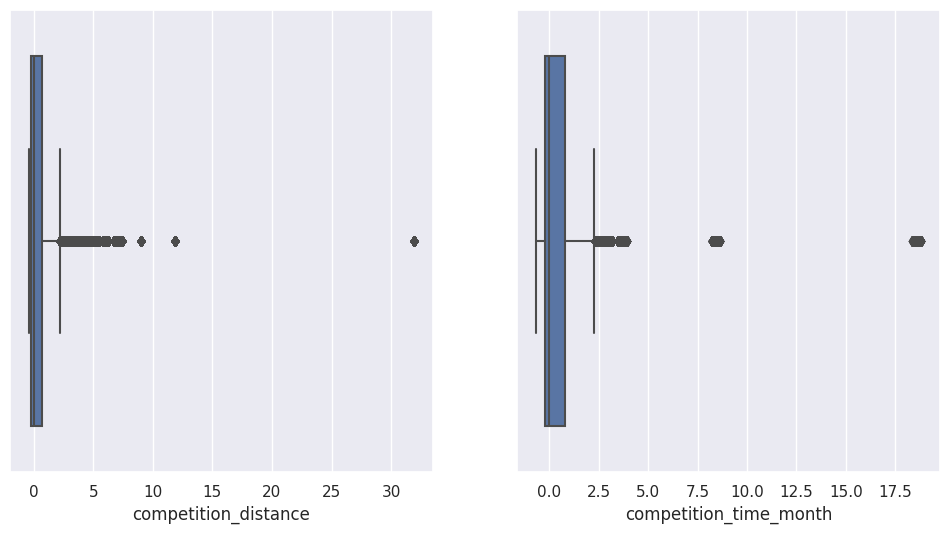

In [70]:
plt.subplot(1, 2, 1)
sns.boxplot(x=df5['competition_distance'])
plt.subplot(1, 2, 2)
sns.boxplot(x=df5['competition_time_month'])

<AxesSubplot: xlabel='year'>

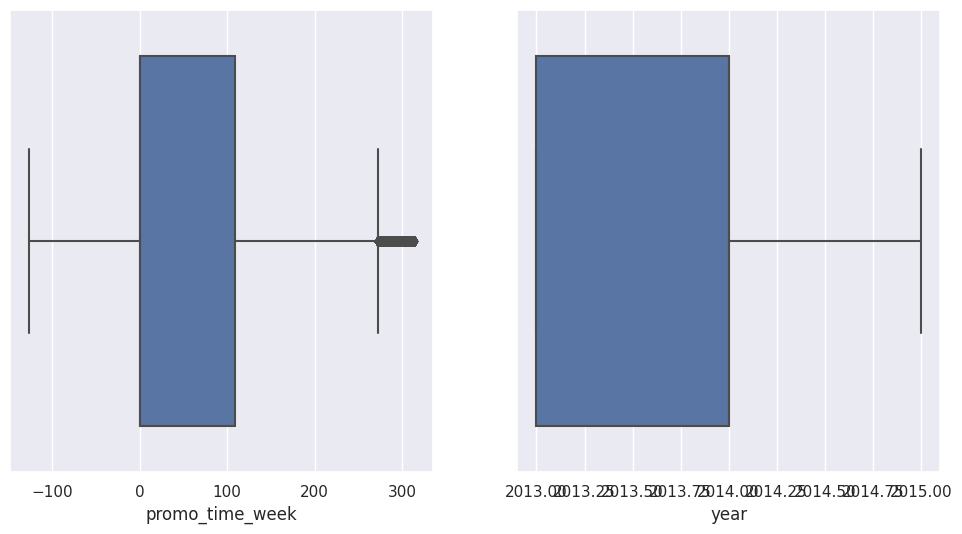

In [63]:
plt.subplot(1, 2, 1)
sns.boxplot(x=df5['promo_time_week'])
plt.subplot(1, 2, 2)
sns.boxplot(x=df5['year'])

In [64]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

<AxesSubplot: xlabel='competition_distance', ylabel='Count'>

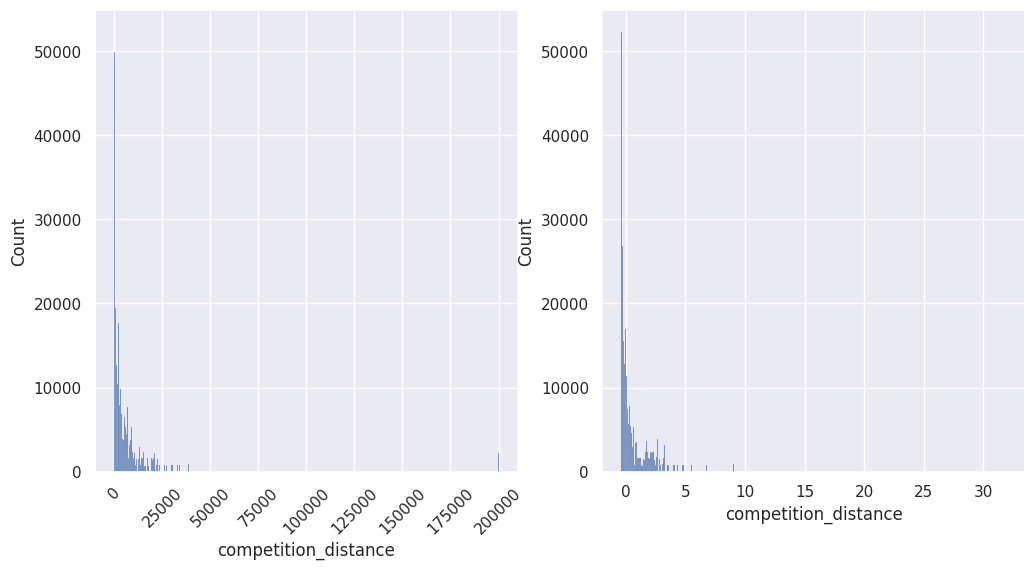

In [65]:
plt.subplot(1, 2, 1)
sns.histplot(df4['competition_distance'])
plt.xticks(rotation=45);
plt.subplot(1, 2, 2)
sns.histplot(df5['competition_distance'])

<AxesSubplot: xlabel='competition_time_month', ylabel='Count'>

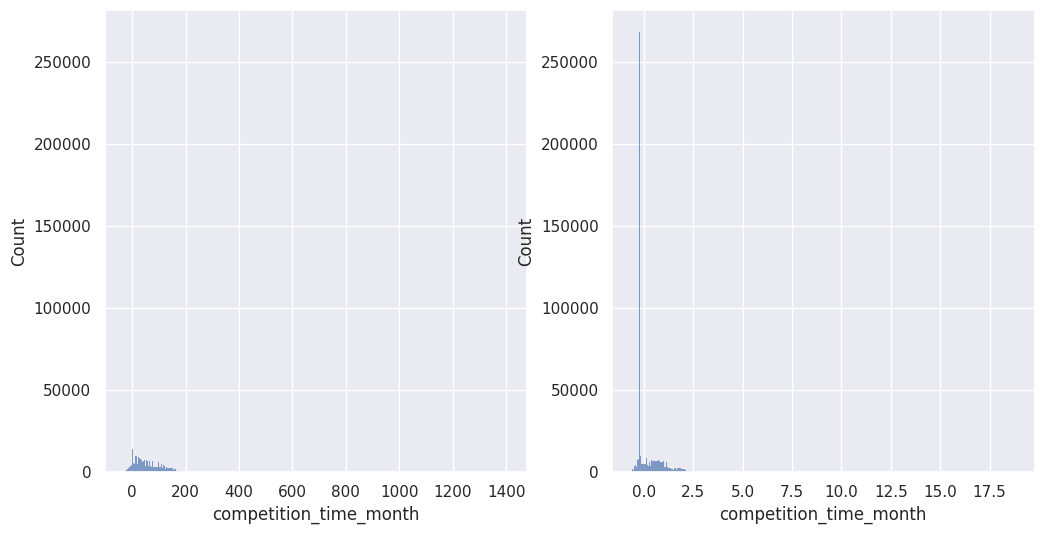

In [66]:
plt.subplot(1, 2, 1)
sns.histplot(df4['competition_time_month'])
plt.subplot(1, 2, 2)
sns.histplot(df5['competition_time_month'])

<AxesSubplot: xlabel='promo_time_week', ylabel='Count'>

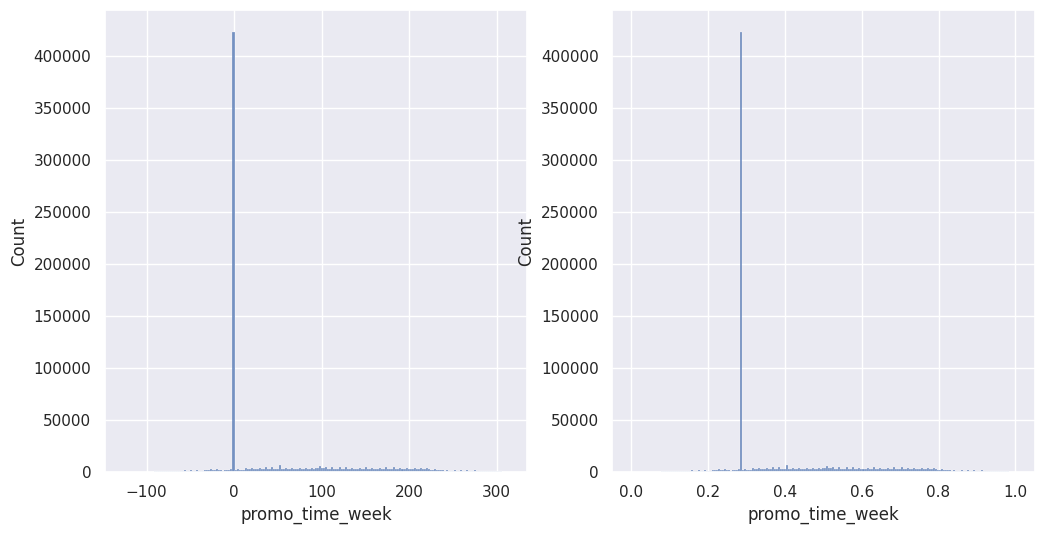

In [67]:
plt.subplot(1, 2, 1)
sns.histplot(df4['promo_time_week'])
plt.subplot(1, 2, 2)
sns.histplot(df5['promo_time_week'])

<AxesSubplot: xlabel='year', ylabel='Count'>

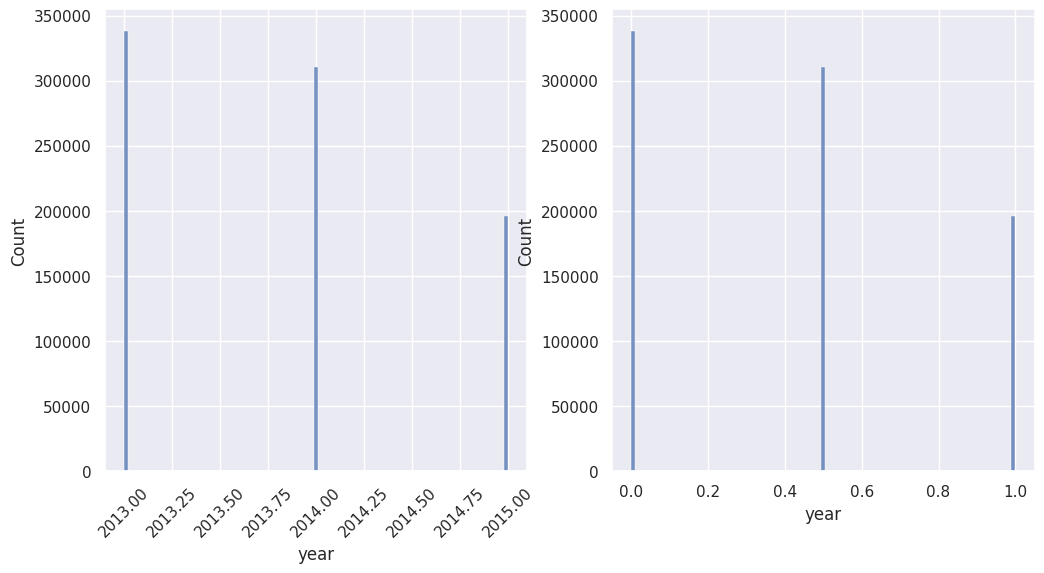

In [68]:
plt.subplot(1, 2, 1)
sns.histplot(df4['year'])
plt.xticks(rotation=45);
plt.subplot(1, 2, 2)
sns.histplot(df5['year'])

## 5.3 Transformação

### 5.3.1 Encoding

In [71]:
df5['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [72]:
df5['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [73]:
df5['assortment'].drop_duplicates()

0       basic
3      extend
258     extra
Name: assortment, dtype: object

In [74]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extend': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformação da Variável Resposta

In [75]:
df5['sales'] = np.log1p(df5['sales'])

<AxesSubplot: xlabel='sales', ylabel='Count'>

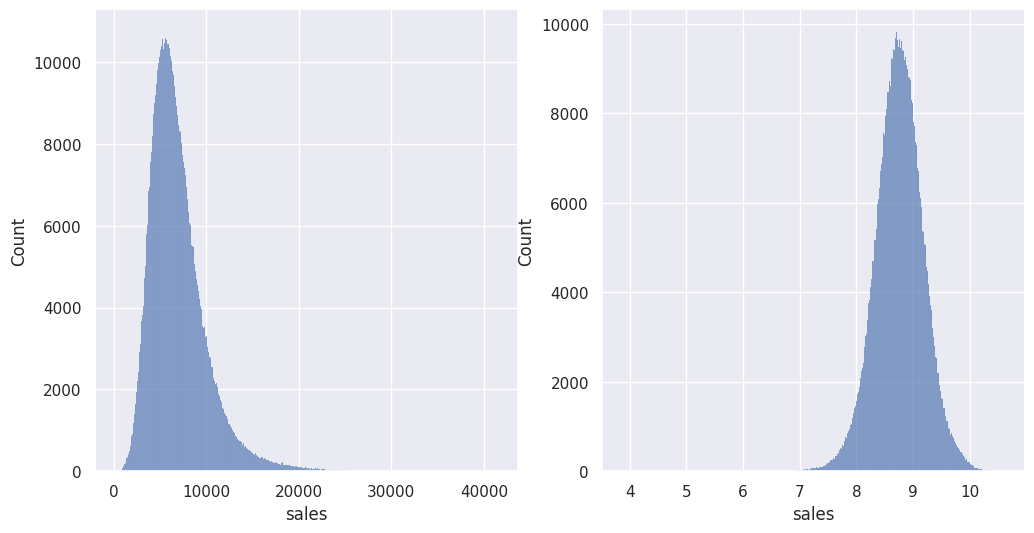

In [76]:
plt.subplot(1, 2, 1)
sns.histplot(df4['sales'])
plt.subplot(1, 2, 2)
sns.histplot(df5['sales'])

### 5.3.3 Transformação de Natureza

In [77]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0 PASSO 06 - SELEÇÃO DE VARIÁVEIS

In [79]:
df6 = df5.copy();

## 6.1 Separando os Dados em Treino e Teste

In [80]:
cols_drop = ['week_of_year','day', 'month', 'day_of_week', 'promo_since', 'competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [81]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7)

Timestamp('2015-06-19 00:00:00')

In [82]:
# dataset de treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# dataset de teste
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Treinamento - Data Min: {}'. format( X_train['date'].min()))
print('Treinamento - Data Max: {}'. format( X_train['date'].max()))

print('\nTeste - Data Min: {}'. format( X_test['date'].min()))
print('Teste - Data Max: {}'. format( X_test['date'].max()))

Treinamento - Data Min: 2013-01-01 00:00:00
Treinamento - Data Max: 2015-06-18 00:00:00

Teste - Data Min: 2015-06-19 00:00:00
Teste - Data Max: 2015-07-31 00:00:00


## 6.2 Seleção de Variáveis com Boruta

In [67]:
# dataset de treino e teste para o Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

In [99]:
# definindo RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# treinando Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Melhores Variáves do Boruta

In [146]:
cols_selected = boruta.support_.tolist()

# melhores variáveis
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# variáveis não selecionadas pelo boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [147]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [148]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3 Seleção de Variáveis Manualmente (evita nova execução do Boruta)

In [83]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# colunas adicionadas novamente
feat_to_add = ['date', 'sales']

# lista final
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 PASSO 07 - MODELANDO MACHINE LEARNING

In [84]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

y_train = X_train['sales']
y_test = X_test['sales']

# y_train e y_teste foram definidos no passo 6.1

## 7.1 Average Model

In [85]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result                           

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [92]:
# modelo
lr = LinearRegression().fit(x_train, y_train)

# predicão
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


In [93]:
# acurácia
lr.score(x_test, y_test)

0.2615024513519747

In [69]:
# acurácia cross
cv_lr = cross_val_score(lr, x_train, y_train)
cv_lr.mean()

0.21113286895534275

In [78]:
# análise predição
df_sales_predict_lr = pd.DataFrame()
df_sales_predict_lr['date'] = X_test.date
df_sales_predict_lr['sales'] = y_test
df_sales_predict_lr['preticted_sales'] = list(yhat_lr)

df_sales_predict_lr.head()

<AxesSubplot: xlabel='date', ylabel='sales'>

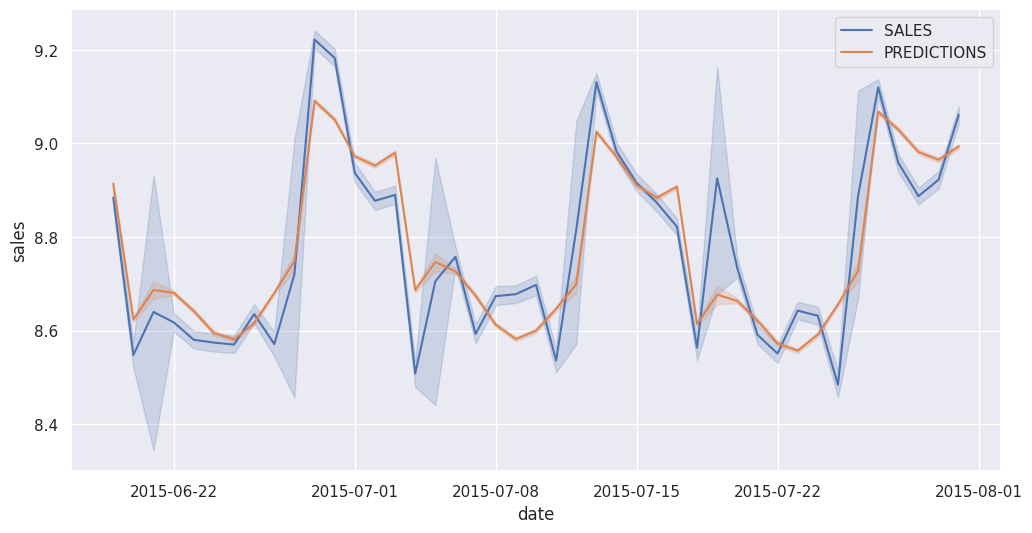

In [80]:
# gráfico predição
sns.lineplot(x='date', y='sales', data=df_sales_predict_lr, label='SALES')
sns.lineplot(x='date', y='preticted_sales', data=df_sales_predict_lr, label='PREDICTIONS')

## 7.3 Random Forest Regressor

In [86]:
# modelo
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# predição
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


In [84]:
# acurácia
rf.score(x_test, y_test)

0.8995404663392272

In [ ]:
# acurácia cross
cv_rf= cross_val_score(rf, x_train, y_train)
cv_rf.mean()

In [87]:
# análise predição
df_sales_predict_rf = pd.DataFrame()
df_sales_predict_rf['date'] = X_test.date
df_sales_predict_rf['sales'] = y_test
df_sales_predict_rf['preticted_sales'] = list(yhat_rf)

df_sales_predict_rf.head()

,date,sales,preticted_sales
0,2015-07-31,8.568646,8.612968
1,2015-07-31,8.710290,8.799275
2,2015-07-31,9.025816,9.129635
3,2015-07-31,9.546527,9.368229
4,2015-07-31,8.481151,8.682084


<AxesSubplot: xlabel='date', ylabel='sales'>

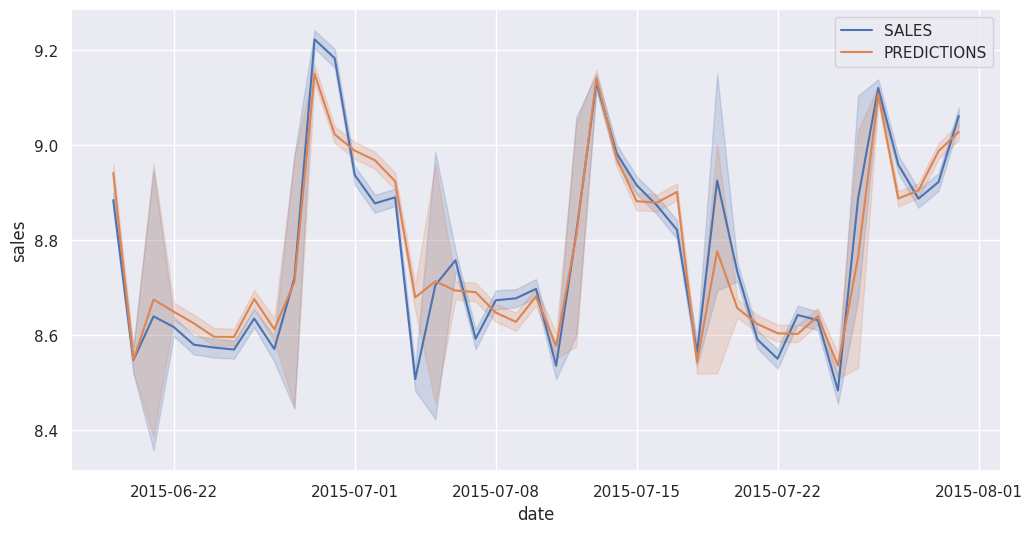

In [89]:
# gráfico predição
sns.lineplot(x='date', y='sales', data=df_sales_predict_rf, label='SALES')
sns.lineplot(x='date', y='preticted_sales', data=df_sales_predict_rf, label='PREDICTIONS')

## 7.4 XGBoost Regressor

In [90]:
# modelo
model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

# predicão
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958204,0.130309,1238.550842


In [164]:
# acurácia
model_xgb.score(x_test, y_test)

0.8379943047206472

In [96]:
# acurácia cross
cv_xgb = cross_val_score(model_xgb, x_train, y_train)
cv_xgb.mean()

0.7747654051986949

In [94]:
# análise predição
df_sales_predict_xgb = pd.DataFrame()
df_sales_predict_xgb['date'] = X_test.date
df_sales_predict_xgb['sales'] = y_test
df_sales_predict_xgb['preticted_sales'] = list(yhat_xgb)

df_sales_predict_xgb.head()

,date,sales,preticted_sales
0,2015-07-31,8.568646,8.839254
1,2015-07-31,8.710290,8.690131
2,2015-07-31,9.025816,9.088619
3,2015-07-31,9.546527,9.420630
4,2015-07-31,8.481151,8.757724


<AxesSubplot: xlabel='date', ylabel='sales'>

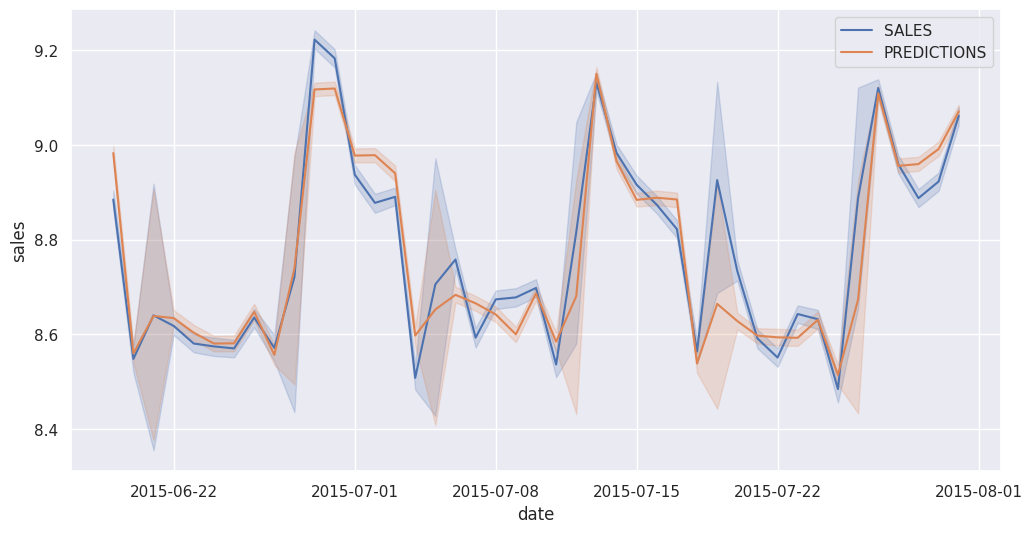

In [95]:
# gráfico predição
sns.lineplot(x='date', y='sales', data=df_sales_predict_xgb, label='SALES')
sns.lineplot(x='date', y='preticted_sales', data=df_sales_predict_xgb, label='PREDICTIONS')

## 7.5 Compare Model's Performance

In [97]:
modelling_result = pd.concat([baseline_result, lr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,XGBoost Regressor,868.958204,0.130309,1238.550842
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215


In [169]:
# positivo (sub estimando) - valor predito tende a ser menor que o valor real
# negativo (super estimando) - valor predito tende a ser maior que o valor real
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_rf))
mpe

-0.019160106033745315

# 8.0 PASSO 08 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [170]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_rf)

/tmp/ipykernel_10212/1182183675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
/tmp/ipykernel_10212/1182183675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_rf)


## 8.1 Performance para o Negócio

In [171]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenarios'] = df92['predictions'] - df92['MAE']
df92['best_scenarios'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenarios', 'best_scenarios', 'MAE', 'MAPE']]

In [172]:
# lojas mais desafiadoras
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenarios,best_scenarios,MAE,MAPE
273,274,214152.629831,213201.455184,215103.804479,951.174647,0.153203
298,299,298538.153325,297039.825169,300036.481482,1498.328157,0.147013
1044,1045,322912.913713,321263.016415,324562.811011,1649.897298,0.140754
467,468,203302.294790,202256.619078,204347.970501,1045.675711,0.128085
309,310,325856.685804,324514.913851,327198.457757,1341.771953,0.120561


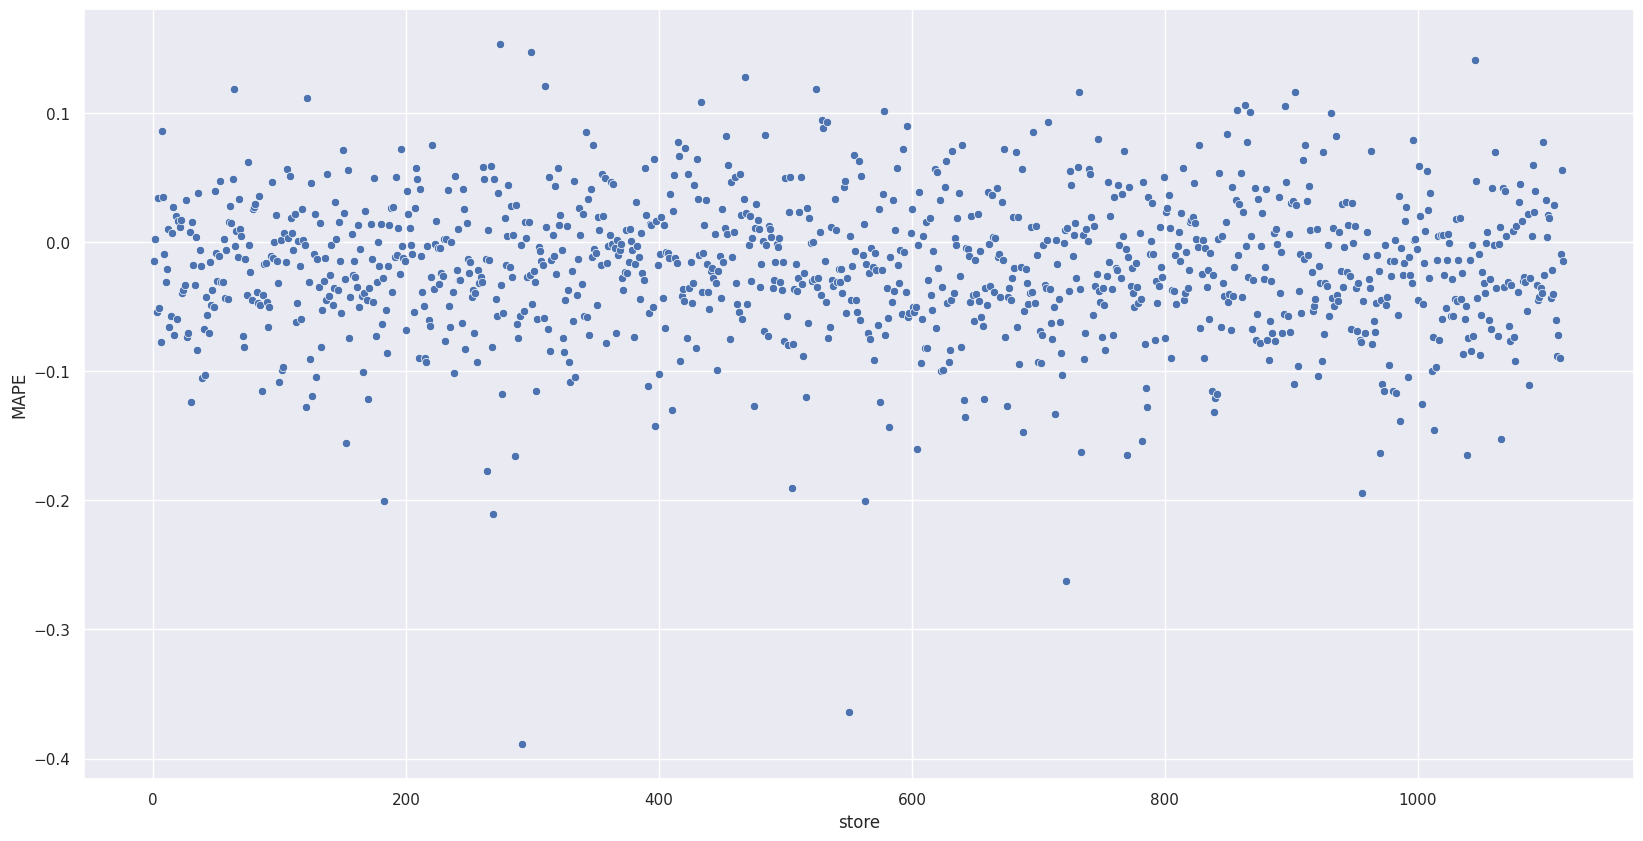

In [173]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 8.2 Performance Total

In [174]:
df93 = df92[['predictions', 'worst_scenarios', 'best_scenarios']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0:'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"R$ 289,356,181.44"
1,worst_scenarios,"R$ 288,595,370.01"
2,best_scenarios,"R$ 290,116,992.86"


## 8.3 Performance Machine Learning

In [175]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/tmp/ipykernel_10212/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/tmp/ipykernel_10212/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


/tmp/ipykernel_10212/434064625.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df9['error'])


<AxesSubplot: xlabel='predictions', ylabel='error'>

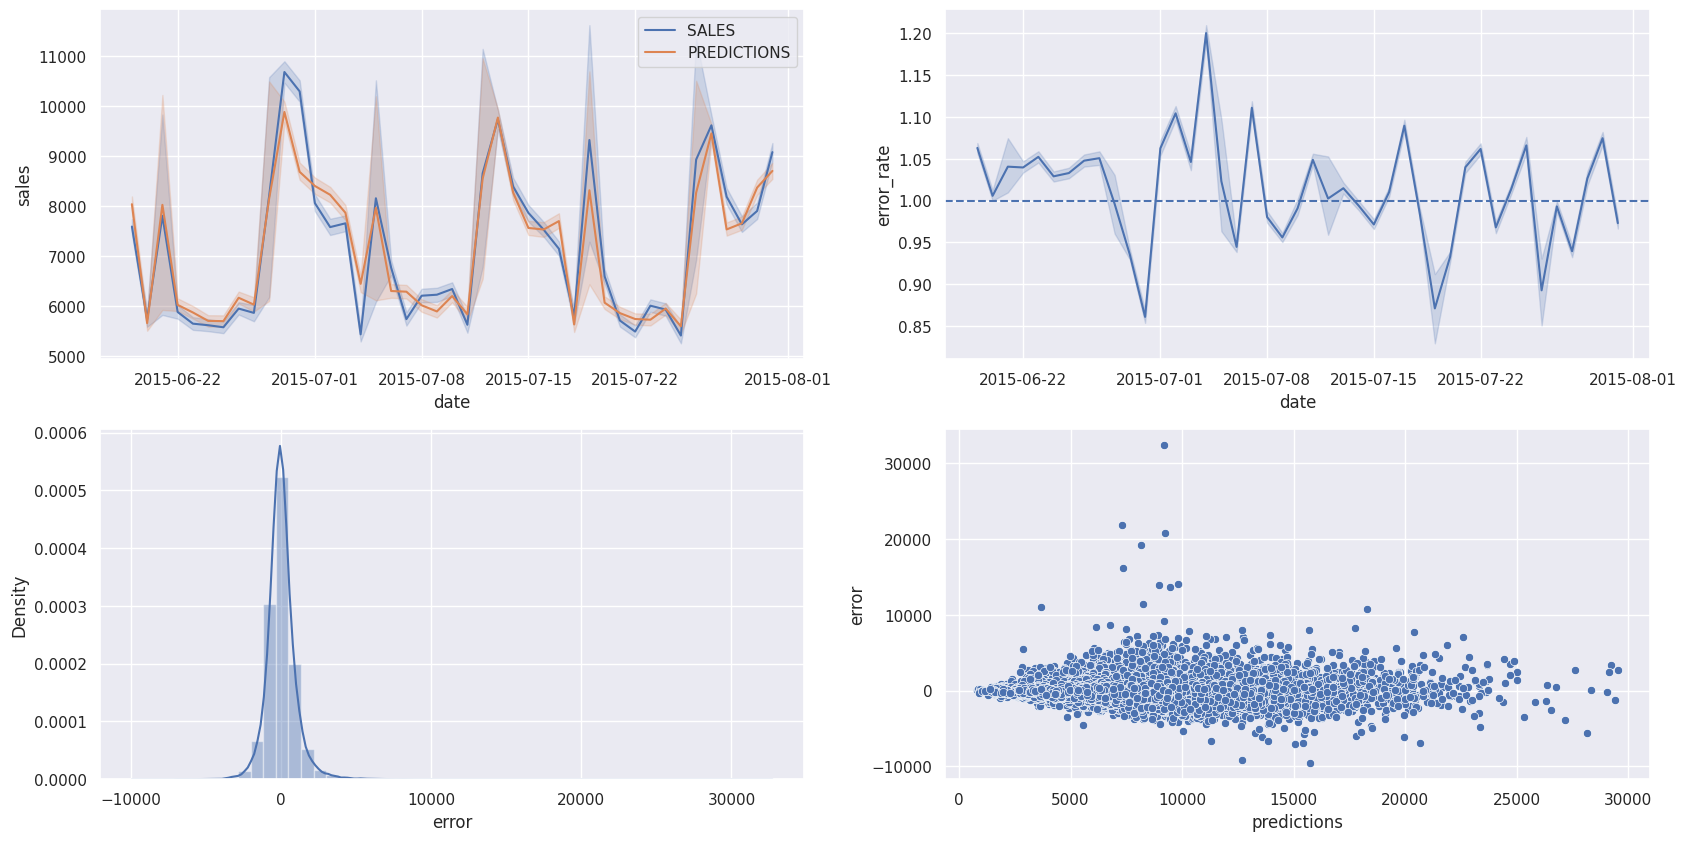

In [176]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

# análise de sub e super estimativa
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

# distribuição do erro
plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

# resíduo
plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error'])